In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
df = pd.read_csv('fmnist_small.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0.0,7.0,0.0,50.0,205.0,196.0,213.0,165.0,0.0,0.0
1,7,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0,0,1,0,0,0,...,142.0,142.0,142.0,21.0,0.0,3.0,0.0,0.0,0.0,0.0
3,8,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0,0,0,0,0,0,0,0,0,...,213.0,203.0,174.0,151.0,188.0,10.0,0.0,0.0,0.0,0.0


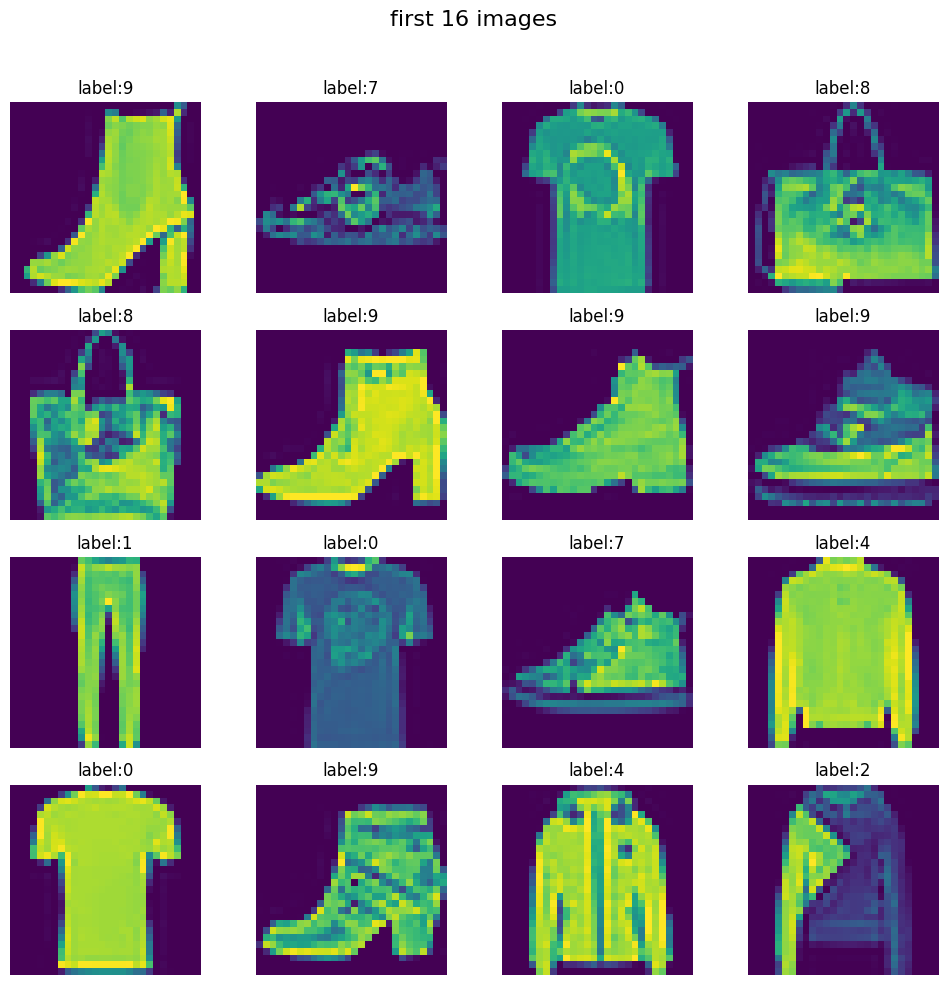

In [4]:
## creating a 4x4 grid of images ...
fig, axes = plt.subplots(4,4, figsize=(10,10))
fig.suptitle("first 16 images", fontsize=16)

## plotting the first 16 images from the dataset

for i, ax in enumerate(axes.flat):
  img = df.iloc[i,1:].values.reshape(28,28)   ## reshape to 28x28
  ax.imshow(img)  ## display the image
  ax.axis('off')  ## turn off the axis
  ax.set_title(f"label:{df.iloc[i,0]}")  ## set the title to the label

plt.tight_layout(rect=[0,0,1,0.96])    ## layout adjust
plt.show()

In [5]:
## train test split

X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
## scaling the features
X_train = X_train/255.0
X_test = X_test/255.0

In [7]:
X_train.shape

(2260, 784)

In [8]:
## create CustomDataset Class

class CustomDataset(Dataset):

  def __init__(self, features, labels):

    self.features = torch.tensor(features, dtype=torch.float32)
    self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
    return len(self.features)

  def __getitem__(self, index):
    return self.features[index], self.labels[index]

In [9]:
## creating train,test objects
train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [10]:
train_dataset[0]

(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0

In [11]:
## creating train and test loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

### Neural Network Design

In [12]:
## this is the Neural Network Class

class MyANN(nn.Module):

  def __init__(self, num_features):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(num_features, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    )


  ## forward pass
  def forward(self, x):
    return self.model(x)

In [13]:
## setting the learning rate and epochs

epochs = 5
learning_rate = 0.1

### Instantiating model

In [14]:
## instantiate the model
model = MyANN(X_train.shape[1])
model = model.to(device)

## loss function
loss_function = nn.CrossEntropyLoss()

## optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [15]:
len(train_loader)

71

### Training loop

In [16]:
## training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)  ### change here to...gpu

    ## forward pass
    outputs = model(batch_features)

    ## calculate loss
    loss = loss_function(outputs, batch_labels)

    ## backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_epoch_loss += loss.item()

  avg_loss = total_epoch_loss / len(train_loader)
  print(f"Epoch: {epoch+1}, Loss: {avg_loss:.4f}")

Epoch: 1, Loss: 1.6991
Epoch: 2, Loss: 0.9683
Epoch: 3, Loss: 0.8252
Epoch: 4, Loss: 0.7550
Epoch: 5, Loss: 0.6664


### Setting the model to eval mode

In [17]:
model.eval()

MyANN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)

### Evaluation

In [18]:
total = 0
correct = 0


with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

  print(correct/total)

0.7380530973451327


In [19]:
len(test_loader)

18

### End ..here